In [1]:
import sys
import glob
import os

import csv
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

import pickle
import numpy as np
import matplotlib.pyplot as plt
from src.metrics import Metrics
import src.optimizers as optimizers
import src.losses as losses
from src.analognn import Model
from src.initializers import Initializers
from src.utils import generate_voltage_values
from src.batchgenerator import BatchGenerator
from src.datasets import *
from src.modelconfig import ModelConfig
from src.analoglayers import (
    InputVoltageLayer,
    BiasVoltageLayer,
    DenseLayer,
    DiodeLayer,
    AmplificationLayer,
    CurrentLayer,
    ConcatenateLayer,
)

In [2]:
def get_config_files(config_path="config", filter="*"):
    return sorted(glob.glob(os.path.join(config_path, f"{filter}.json")))

In [3]:
def init_model_from_config(config_file):
    """
    Takes the path to a config file, loads the ModelConfig,
    and returns (model, dataset, model_params, name).
    """
    name = os.path.splitext(os.path.basename(config_file))[0]
    
    config = ModelConfig(config_file)
    
    dataset = config.initialize_dataset()
    model_params = config.initialize_model_params(dataset)

    input_units        = model_params["input_units"]
    output_units       = model_params["output_units"]
    hidden_1_units     = model_params["hidden_1_units"]
    bias_p             = model_params["bias_p"]
    bias_n             = model_params["bias_n"]
    down_diode_bias    = model_params["down_diode_bias"]
    up_diode_bias      = model_params["up_diode_bias"]
    weight_initializer = model_params["weight_initializer"]
    diode_params       = model_params["diode_params"]
    amp_params         = model_params["amp_params"]
    lr                 = model_params["lr"]

    # input layer
    xp  = InputVoltageLayer(units=input_units, name='xp')
    xn = InputVoltageLayer(units=input_units, name='xn')
    b1_p = BiasVoltageLayer(units=1, name='b1_p', bias_voltage=bias_p)
    b1_n = BiasVoltageLayer(units=1, name='b1_n', bias_voltage=bias_n)
    j1 = ConcatenateLayer(name='j1')([xp, xn, b1_p, b1_n])

    # hidden dense layer 1
    d1 = DenseLayer(units=hidden_1_units, lr=lr, name='d1', initializer=weight_initializer, trainable=True)(j1)
    a1_1 = DiodeLayer(name='act1_1', direction='down', bias_voltage=down_diode_bias, trainable=False, kind="behavioral", param=diode_params)(d1)
    a1_2 = DiodeLayer(name='act1_2', direction='up', bias_voltage=up_diode_bias, trainable=False, kind="behavioral", param=diode_params)(a1_1)
    g1 = AmplificationLayer(name='amp1', param=amp_params)(d1)

    # layer before last
    b2_p = BiasVoltageLayer(units=1, name='b2_p', bias_voltage=bias_p)
    b2_n = BiasVoltageLayer(units=1, name='b2_n', bias_voltage=bias_n)
    j2 = ConcatenateLayer(name='j2')([g1, b2_p, b2_n])

    # output layer
    d_out = DenseLayer(units=2 * output_units, lr=lr, name='d_out', initializer=weight_initializer, trainable=True)(j2)
    c_out = CurrentLayer(name='out')(d_out)

    model = Model(inputs=[xp, xn, b1_p, b2_p, b1_n, b2_n], outputs=[c_out])
    
    return model, dataset, model_params, name

In [4]:
def save_dense_weights(model, file_path):
    if not file_path:
        print("No file path specified, skipping save.")
        return

    weights_to_save = {}

    for layer in model.computation_graph:
        if isinstance(layer, DenseLayer):
            layer_weight_array = np.zeros(layer.w.shape)

            for i in range(layer.w.shape[0]):
                for j in range(layer.w.shape[1]):
                    layer_weight_array[i, j] = layer.w[i, j].W

            weights_to_save[layer.name] = layer_weight_array

    np.save(file_path, weights_to_save, allow_pickle=True)
    print(f"Saved weights to {file_path}")


def load_dense_weights(model, file_path, weight_initializer):
    if file_path is None:
        print('No weights to load')
        return

    weights = np.load(file_path, allow_pickle=True).item()

    if weight_initializer.params['memristor'] == 'linear':
        for layer in model.computation_graph:
            if isinstance(layer, DenseLayer) and layer.name in weights:
              for i in range(layer.w.shape[0]):
                for j in range(layer.w.shape[1]):
                  G = weights[layer.name][i, j]
                  layer.w[i, j].W = G
                  layer.w[i, j]._update_memristance(0, 0)
    elif weight_initializer.params['memristor'] == 'yacopcic':
        for layer in model.computation_graph:
            if isinstance(layer, DenseLayer) and layer.name in weights:
              for i in range(layer.w.shape[0]):
                for j in range(layer.w.shape[1]):
                  G = weights[layer.name][i, j]
                  M = 1.0 / G
                  x_init = 1.0 / (M * layer.w[i, j].a1 * np.sinh(layer.w[i, j].b))
                  layer.w[i, j].x = x_init
                  layer.w[i, j]._update_memristance()
    elif weight_initializer.params['memristor'] == 'vteam':
        for layer in model.computation_graph:
            if isinstance(layer, DenseLayer) and layer.name in weights:
              for i in range(layer.w.shape[0]):
                for j in range(layer.w.shape[1]):
                  G = weights[layer.name][i, j]
                  M = 1.0 / G
                  w_init = layer.w[i, j].w_on + (layer.w[i, j].w_off - layer.w[i, j].w_on) / np.log(layer.w[i, j].R_off / layer.w[i, j].R_on) * np.log(M / layer.w[i, j].R_on)
                  layer.w[i, j].w = w_init
                  layer.w[i, j]._update_memristance()
    elif weight_initializer.params['memristor'] == 'mms':
        for layer in model.computation_graph:
            if isinstance(layer, DenseLayer) and layer.name in weights:
              for i in range(layer.w.shape[0]):
                for j in range(layer.w.shape[1]):
                  G = weights[layer.name][i, j]
                  x_init = (G * layer.w[i, j].R_on * layer.w[i, j].R_off - layer.w[i, j].R_on) / (layer.w[i, j].R_off - layer.w[i, j].R_on)
                  layer.w[i, j].x = x_init
                  layer.w[i, j]._update_memristance()
    else:
        for layer in model.computation_graph:
          if isinstance(layer, DenseLayer) and layer.name in weights:
            for i in range(layer.w.shape[0]):
              for j in range(layer.w.shape[1]):
                G = weights[layer.name][i, j]
                M = 1.0 / G
                layer.w[i, j].w = layer.w[i, j].D * (M - layer.w[i, j].R_OFF) / (layer.w[i, j].R_ON - layer.w[i, j].R_OFF)
                layer.w[i, j]._update_memristance()

    print('Loaded weights from', file_path)

In [5]:
def train_and_evaluate_model(model, dataset, model_params, name, output_path="output", verbose=False):
    """
    Trains the model using the given model_params, plots the loss,
    and saves results to a CSV file in the specified output_path.
    """
    
    # Load weights path, if available
    load_weights_path = model_params.get("load_weights_path", None)
    load_dense_weights(model, load_weights_path, model_params["weight_initializer"])

    # Training parameters
    beta            = model_params["beta"]
    dt_scaling      = model_params["dt_scaling"]
    epochs          = model_params["epochs"]
    modulation_mode = model_params["modulation_mode"]
    V_const         = model_params["V_const"]
    frequency       = model_params["frequency"]

    # Optimizer, Loss & Metrics
    optimizer = optimizers.Adam(
        model,
        beta=beta,
        dt_scaling=dt_scaling,
        modulation_mode=modulation_mode,
        V_const=V_const,
        frequency=frequency)
    
    loss_fn   = losses.MSE(output_midpoint=dataset.output_midpoint)
    metrics   = Metrics(model, verbose=verbose, validate_every={"epoch_num": 10})

    # Training
    model.fit(train_dataloader=dataset.train_dataloader,
              beta=beta,
              epochs=epochs,
              loss_fn=loss_fn,
              optimizer=optimizer,
              test_dataloader=dataset.test_dataloader,
              metrics=metrics)

    # Extract training loss
    mean_losses = []
    iterations   = []

    for epoch_num in range(1, model.epochs):
        if model.dataset_size != model.batch_size:
            # Batch-wise
            current_total_losses = []
            for batch_num in range(model.num_batches):
                current_total_losses.append(model.total_loss['out'][epoch_num][batch_num] / model.batch_size)
            mean_losses.append(np.mean(current_total_losses))
        else:
            # Epoch-wise
            mean_losses.append(np.mean(model.total_loss['out'][epoch_num] / model.dataset_size))
        
        iterations.append(epoch_num)

    # Show plot
    plt.figure()
    plt.title(f"Total Loss: {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.plot(iterations, mean_losses, label=name)
    plt.legend()
    plt.show()

    # CSV output
    os.makedirs(output_path, exist_ok=True)
    csv_file = os.path.join(output_path, f"{name}.csv")

    with open(csv_file, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Total Loss"])
        for epoch, loss in zip(iterations, mean_losses):
            writer.writerow([epoch, loss])

    print(f"Training for {name} completed.")
    print(f"Training results saved in {csv_file}.\n")

In [6]:
def run_all_experiments(verbose):
    config_files = get_config_files("config")
    for config_file in config_files:
        print(f"Starting experiment with configuration: {config_file}")
        model, dataset, model_params, name = init_model_from_config(config_file)
        train_and_evaluate_model(model, dataset, model_params, name, output_path="output", verbose=verbose)


def run_experiments_from_filter(filter, verbose):
    config_files = get_config_files("config", filter)
    for config_file in config_files:
        print(f"Starting experiment with configuration: {config_file}")
        model, dataset, model_params, name = init_model_from_config(config_file)
        train_and_evaluate_model(model, dataset, model_params, name, output_path="output", verbose=verbose)


def run_experiments_from_list(config_names, verbose):
    for name in config_names:
        config_file = os.path.join("config", f"{name}.json")
        print(f"Starting experiment with configuration: {config_file}")
        model, dataset, model_params, name = init_model_from_config(config_file)
        train_and_evaluate_model(model, dataset, model_params, name, output_path="output", verbose=verbose)

Starting experiment with configuration: config\pam_breast_cancer_biolek.json
Loaded weights from weights/breast_cancer_1e2_1e5.npy


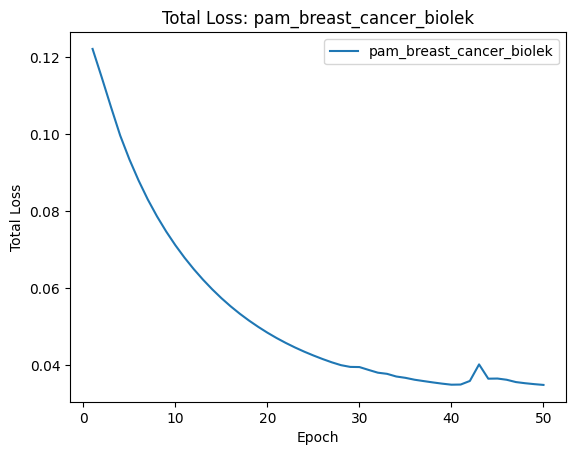

Training for pam_breast_cancer_biolek completed.
Training results saved in output\pam_breast_cancer_biolek.csv.

Starting experiment with configuration: config\pam_iris_biolek.json
Loaded weights from weights/iris_1e2_1e5.npy


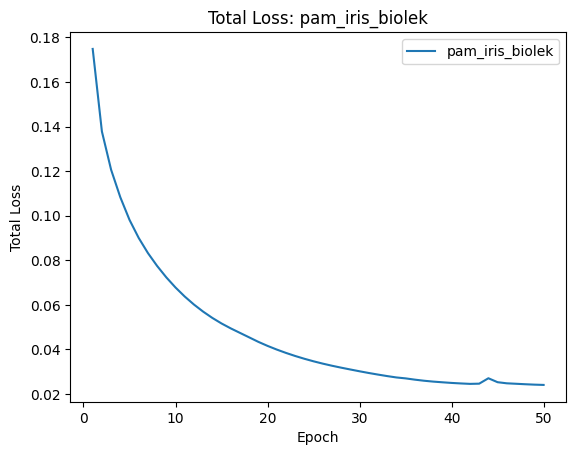

Training for pam_iris_biolek completed.
Training results saved in output\pam_iris_biolek.csv.

Starting experiment with configuration: config\pwm_breast_cancer_biolek.json
Loaded weights from weights/breast_cancer_1e2_1e5.npy


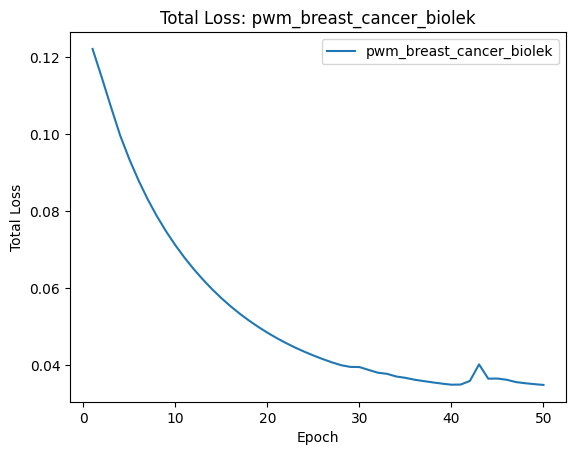

Training for pwm_breast_cancer_biolek completed.
Training results saved in output\pwm_breast_cancer_biolek.csv.

Starting experiment with configuration: config\pwm_iris_biolek.json
Loaded weights from weights/iris_1e2_1e5.npy


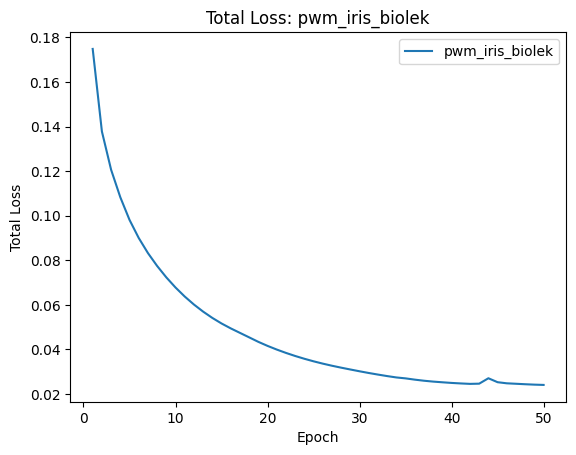

Training for pwm_iris_biolek completed.
Training results saved in output\pwm_iris_biolek.csv.



In [7]:
run_experiments_from_filter('*biolek*', False)